In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

# Define the dataset class
class FaceVerificationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
        image_paths = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        return image

# Set the root directory of your dataset
root_dir = "C:\\Users\\gojas\\Downloads\\test"

# Create an instance of the dataset
dataset = FaceVerificationDataset(root_dir)

# Create MTCNN face detector for face detection and alignment
mtcnn = MTCNN()

# Create InceptionResnetV1 model for face recognition
model = InceptionResnetV1(pretrained='vggface2').eval()

# Custom collate function to convert PIL Images to tensors
def custom_collate_fn(batch):
    batch_images = []
    for image in batch:
        image = image.resize((160, 160))  # Resize the image to a consistent size
        image = transforms.ToTensor()(image)
        batch_images.append(image)
    return torch.stack(batch_images)

# Create a data loader for the dataset with the custom collate function
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# Specify the device to be used (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
model = model.to(device)

# Extract embeddings for face verification
embeddings = []
for images in data_loader:
    with torch.no_grad():
        # Preprocess images and detect faces
        aligned_images = images.to(device)

        # Compute embeddings
        batch_embeddings = model(aligned_images)
        embeddings.extend(batch_embeddings.detach().cpu().numpy())
    torch.cuda.empty_cache()

In [4]:
def compare_embeddings(embedding1, embedding2):
    # Compute L2 distance between embeddings
    distance = np.linalg.norm(embedding1 - embedding2)
    return distance

In [114]:
labels_file = "C:\\Users\\gojas\\Downloads\\val.txt"
# Load the labels from the text file
labels = []
with open(labels_file, 'r') as f:
    lines = f.readlines()[1:]  # Skip the header line
    for line in lines:
        _, label = line.strip().split(',')
        label = int(label.strip())
        labels.append(label)
labels = np.array(labels)

In [7]:
embeddings_array = np.array(embeddings)
predicted_labels = []

for i in range(0, len(embeddings_array), 2):
    condition = compare_embeddings(embeddings_array[i], embeddings_array[i+1]) < 1
    if np.all(condition):
        predicted_labels.append(1)  
    else:
        predicted_labels.append(0)  


# Calculate accuracy
#accuracy = np.mean(predicted_labels == labels)
#print(f"Accuracy: {accuracy}")




In [8]:
with open('output.txt', 'w') as f:
    # Write each element of the output_data list to a new line in the file
    for item in predicted_labels:
        f.write(str(item) + '\n')

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
f1_score = f1_score(labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


Accuracy: 0.96
Precision: 0.9555555555555556
Recall: 0.9555555555555556
F1-score: 0.9555555555555556


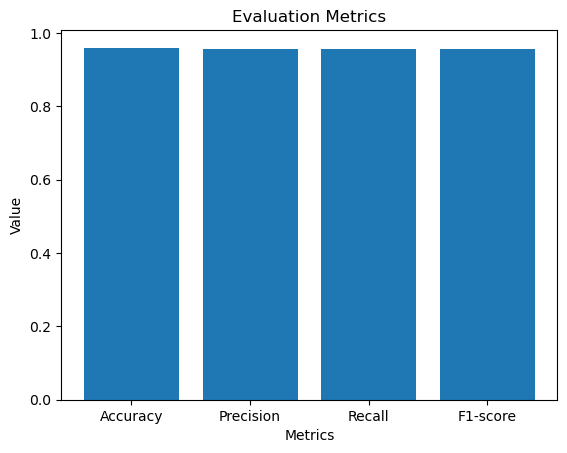

In [127]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1_score]

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.show()


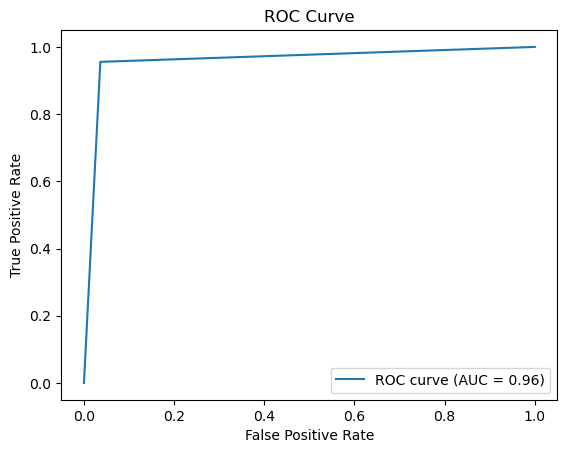

In [129]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(labels, predicted_labels)
auc = roc_auc_score(labels, predicted_labels)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


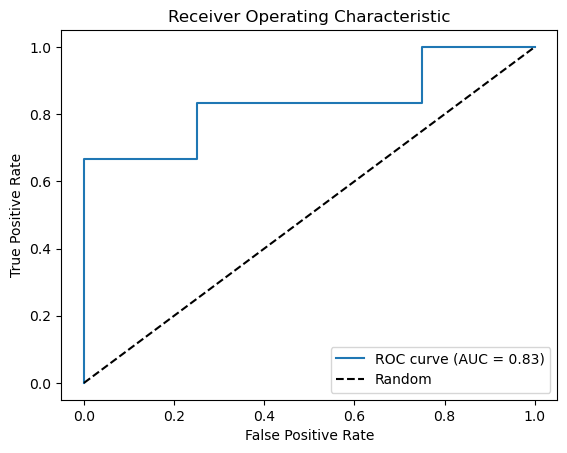

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Generate example data
y_true = np.array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1])
y_scores = np.array([0.1, 0.3, 0.2, 0.8, 0.9, 0.4, 0.6, 0.7, 0.5, 0.75])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate AUC
auc = roc_auc_score(y_true, y_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [9]:
# used chat gpt as a resource 